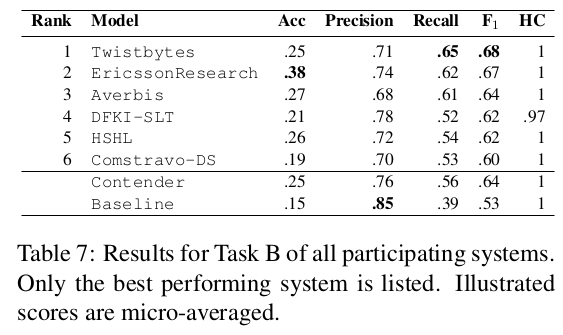

# Approach-01: Germeval-2019

## Requirements

In [ ]:
! wget https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/germeval-2019-hmc/germeval2019t1-public-data-final.zip
! unzip -u -q germeval2019t1-public-data-final.zip
! ls -la

! pip install git+https://github.com/fbenites/sklearn-hierarchical-classification.git
! pip install spacy augmenty
! python -m spacy download de_core_news_sm

--2025-05-12 10:18:26--  https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/germeval-2019-hmc/germeval2019t1-public-data-final.zip
Resolving www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)... 134.100.36.5
Connecting to www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)|134.100.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘germeval2019t1-public-data-final.zip’

germeval2019t1-publ     [                <=> ]  13.27M   880KB/s    in 16s     

2025-05-12 10:18:44 (839 KB/s) - ‘germeval2019t1-public-data-final.zip’ saved [13915224]

total 49368
drwxr-xr-x 1 root root     4096 May 12 10:18 .
drwxr-xr-x 1 root root     4096 May 12 10:17 ..
-rw-r--r-- 1 root root   233276 Jun  7  2019 blurbs_dev_label.txt
-rw-r--r-- 1 root root  1920753 Jun  7  2019 blurbs_dev_nolabel.txt
-rw-r--r-- 1 root root  2630464 Jun  7  2019 blurbs_dev.txt
-rw-r--r-- 1 root root   469047 Aug  9  2019 blurbs_test_label.txt
-rw-r--r-- 1 root

## Preprocessing


*   Data loading
*   Upsampling
*   Hierarchy extraction
*   Metadata handling



### Data loading function

Extraction from xml like .txt structure with metadata, returning data and labels sperately

Data structure of dict:
*   ['authors']
*   ['year']
*   ['isbn']
*   ['title']
*   ['body']
*   ['isbn_pub']
*   ['isbn_grp']

Data:
* train_data, train_labels
* dev_data, dev_labels
* test_data, test_labels




In [ ]:
from bs4 import BeautifulSoup

def read_data(fn):
    with open(fn, 'r', encoding='UTF-8') as file_xml:
        soup = BeautifulSoup(file_xml, 'html.parser')  # Parse with XML parser

    books = soup.find_all('book')
    data = []
    labels = []

    for book in books:
        isbn = book.isbn.text
        # Extract basic metadata
        book_data = {
            'title': book.title.text if book.title else None,
            'authors': [author.strip() for author in book.authors.text.split(',')],
            'body': book.body.text if book.body else None,
            'isbn': isbn,
            'isbn_grp': isbn[4:6],
            'isbn_pub': isbn[6:10],
            'year': book.published.text.split('-')[0]
        }
        data.append(book_data)

        # Process hierarchical categories
        current_labels = []
        categories = book.find('categories')

        if categories:
            for category in categories.find_all('category'):
                topics = category.find_all('topic')
                for topic in topics:
                    label = f"{topic['d']}_{topic.text.replace('&amp;', '&')}"
                    current_labels.append(label)

        labels.append(current_labels)

    return data, labels

In [ ]:
train_data, train_labels = read_data("blurbs_train.txt")
dev_data, dev_labels     = read_data("blurbs_dev.txt")
test_data, test_labels   = read_data("blurbs_test.txt")

### Hierarchy extraction function
Extracts different levels of hierarchy for proper classification returning hierarchy and levels seperately

Data:
* hierarchy, levels
* class_hierarchy

In [ ]:
def read_hierarchy(fn):
    parents_raw={}
    with open(fn, 'r') as file_csv:
        for l1 in file_csv:
            ws=l1.split("\t")
            parents_raw[ws[1].strip()]=ws[0]
    levels={}
    roots=[]
    for item in parents_raw.values():
        if item not in parents_raw.keys():
            levels[item]=0
            roots.append(item)
    for i in range(1,3):
        mkeys=list(levels.keys())
        for item in mkeys:
            for child in parents_raw.keys():
                if parents_raw[child]==item:

                    if child not in levels:
                        levels[child]=levels[item]+1

    hierarchy={"ROOT":[]}
    for tk,tv in parents_raw.items():
        par=str(levels[tv])+"_"+tv
        if par in hierarchy:
            hierarchy[par].append(str(levels[tk])+"_"+tk)
        else:
            hierarchy[par]=[str(levels[tk])+"_"+tk]
    for par in hierarchy:
        if len([tk for tk in hierarchy.values() if par in tk ])==0:
            if par=="ROOT":
                continue
            hierarchy["ROOT"].append(par)
    return hierarchy, levels

In [ ]:
from sklearn_hierarchical_classification.constants import ROOT

hierarchy, levels = read_hierarchy("hierarchy.txt")

if "ROOT" in hierarchy:
  hierarchy[ROOT] = hierarchy["ROOT"]
  del hierarchy["ROOT"]
class_hierarchy = hierarchy

### Upsampling
Based on list of categories, the data will be upsampled

Boosted Categories:
* 'Sachbuch'
* 'Kinderbuch & Jugendbuch'
* 'Ratgeber'

Upsampling of train_data, train_labels

In [ ]:
from collections import defaultdict
from random import choices
from math import ceil
import pandas as pd

def over_sample_by_category(data, labels, hierarchy, boost_categories, pct=0.15, boosting_rounds=1):
    books_df = pd.DataFrame(data)
    books_df['labels'] = ['\t'.join(label_list) for label_list in labels]

    samples_to_generate = books_df.shape[0] * pct
    category_map = defaultdict(list)
    category_upsample_count = {}

    # Build category mapping
    for idx, label_str in enumerate(books_df['labels']):
        for label in label_str.split('\t'):
            category_map[label].append(idx)

    category_count = {k: len(v) for k, v in category_map.items()}
    category_count_ = pd.Series(category_count)
    mean_size = int(category_count_.mean())
    minority_categories = category_count_[category_count_ < category_count_.mean()].index.unique()
    mean_increment = ceil(samples_to_generate / len(minority_categories))

    samples_data = []
    samples_labels = []
    actual_samples_generated = 0

    for cat in minority_categories:
        mean_diff = mean_size - category_count[cat]
        num_samples_to_add = min(mean_diff, mean_increment)
        actual_samples_generated += num_samples_to_add
        category_upsample_count[cat] = num_samples_to_add

        # Get original samples
        indices = choices(category_map[cat], k=num_samples_to_add)
        for idx in indices:
            samples_data.append(data[idx].copy())
            samples_labels.append([cat])  # Single-label for upsampled

        # Boosting rounds for specific categories
        for _ in range(boosting_rounds):
            if any(cat.startswith(f"{level}_{bc}") for bc in boost_categories
                  for level in range(len(hierarchy))):
                samples_to_add = min(mean_increment, category_count[cat])
                indices = choices(category_map[cat], k=samples_to_add)
                for idx in indices:
                    samples_data.append(data[idx].copy())
                    samples_labels.append([cat])

    # Combine original and upsampled
    upsampled_data = data + samples_data
    upsampled_labels = labels + samples_labels

    return upsampled_data, upsampled_labels, actual_samples_generated

In [ ]:
boost_categories = ['Sachbuch', 'Kinderbuch~&~Jugendbuch', 'Ratgeber']

train_data, train_labels, count = over_sample_by_category(
    train_data, train_labels, hierarchy, boost_categories
)

### Prepare Metadata

In [ ]:
from collections import Counter

def get_top_authors(data, top_n=500):
    """Get top N most frequent authors, properly handling empty/missing authors."""
    all_authors = []
    for book in data:
        # Safely get authors list (handle missing 'authors' key)
        authors = book.get('authors', [])
        # Filter out empty strings and None values
        valid_authors = [auth for auth in authors if auth and str(auth).strip()]
        all_authors.extend(valid_authors)

    # Count authors - no need to pop empty string since we filtered earlier
    author_counts = Counter(all_authors)

    # Include UNK token in top authors
    top_authors = {author for author, _ in author_counts.most_common(top_n)}
    top_authors.add('[UNK]')
    return top_authors

def get_top_isbn_pub(data, top_n=500):
    """Get top N most frequent ISBN publishers."""
    all_isbn_pub = []
    for book in data:
        all_isbn_pub.append(book['isbn_pub'])  # isbn_pub is a string

    pub_counts = Counter(all_isbn_pub)
    top_list = {pub for pub, _ in pub_counts.most_common(top_n)}
    top_list.add('[UNK_PUB]')
    return top_list

def get_top_isbn_grp(data, top_n=25):
    """Get top N most frequent ISBN groups."""
    all_isbn_grp = []
    for book in data:
        all_isbn_grp.append(book['isbn_grp'])  # isbn_grp is a string

    grp_counts = Counter(all_isbn_grp)
    top_list = {grp for grp, _ in grp_counts.most_common(top_n)}
    top_list.add('[UNK_GRP]')
    return top_list

In [ ]:
def filter_rare_features(data, top_authors, top_isbn_pub, top_isbn_grp):
    filtered_data = []

    for book in data:
        # Filter authors
        filtered_authors = [
                author for author in book['authors']
                if author.strip() in top_authors
        ]

        if not filtered_authors:  # If no authors remain, use '[UNK]'
            filtered_authors = ['[UNK]']

        # Filter ISBN features
        isbn_pub = book['isbn_pub'] if book['isbn_pub'] in top_isbn_pub else '[UNK_PUB]'
        isbn_grp = book['isbn_grp'] if book['isbn_grp'] in top_isbn_grp else '[UNK_GRP]'

        body = book['body'] if book.get('body', '').strip() else '[NO_CONTENT]'

        # Create new book entry
        filtered_book = {
            'title': book['title'],
            'authors': filtered_authors,
            'body': body,
            'isbn': book['isbn'],
            'isbn_grp': isbn_grp,
            'isbn_pub': isbn_pub,
            'year': book['year']
        }
        filtered_data.append(filtered_book)

    return filtered_data

top_authors = get_top_authors(train_data, top_n=500)
top_isbn_pub = get_top_isbn_pub(train_data, top_n=300)
top_isbn_grp = get_top_isbn_grp(train_data, top_n=25)

train_data = filter_rare_features(train_data, top_authors, top_isbn_pub, top_isbn_grp)
dev_data = filter_rare_features(dev_data, top_authors, top_isbn_pub, top_isbn_grp)
test_data = filter_rare_features(test_data, top_authors, top_isbn_pub, top_isbn_grp)

#### Analyze Metadata

In [ ]:
from collections import Counter

def count_feature_thresholds(data, thresholds=[0, 1, 5, 10, 20]):
    """Count features appearing at different threshold levels with full statistics"""
    # Initialize counters
    author_counts = Counter()
    grp_counts = Counter()
    pub_counts = Counter()

    # Count all features
    for book in data:
        # Authors (list)
        for author in book['authors']:
            author_counts[author] += 1

        # ISBN features (strings)
        grp_counts[book['isbn_grp']] += 1
        pub_counts[book['isbn_pub']] += 1

    # Generate results for all thresholds
    results = {}
    for min_books in thresholds:
        results[min_books] = {
            'authors': sum(1 for cnt in author_counts.values() if cnt >= min_books),
            'isbn_grp': sum(1 for cnt in grp_counts.values() if cnt >= min_books),
            'isbn_pub': sum(1 for cnt in pub_counts.values() if cnt >= min_books),
            'total_authors': len(author_counts),
            'total_grps': len(grp_counts),
            'total_pubs': len(pub_counts)
        }

    return results

def print_threshold_analysis(results):
    """Print formatted analysis of feature frequencies"""
    print("\nFeature Frequency Analysis")
    print("="*50)
    print(f"{'Threshold':<10} | {'Authors':<12} | {'ISBN Groups':<12} | {'ISBN Pubs':<12} | Coverage")
    print("-"*50)

    for threshold, counts in sorted(results.items()):
        # Calculate coverage percentages
        auth_cov = 100 * counts['authors'] / counts['total_authors']
        grp_cov = 100 * counts['isbn_grp'] / counts['total_grps']
        pub_cov = 100 * counts['isbn_pub'] / counts['total_pubs']

        print(f"{threshold:<10} | {counts['authors']:<12} | {counts['isbn_grp']:<12} | {counts['isbn_pub']:<12} | "
              f"Authors: {auth_cov:.1f}%, Groups: {grp_cov:.1f}%, Pubs: {pub_cov:.1f}%")

    print("\nKey Statistics:")
    print(f"- Unique authors: {results[0]['total_authors']}")
    print(f"- Unique ISBN groups: {results[0]['total_grps']}")
    print(f"- Unique ISBN publishers: {results[0]['total_pubs']}")

# Usage
thresholds = [0, 1, 5, 10, 20, 50, 100]
results = count_feature_thresholds(train_data, thresholds)
print_threshold_analysis(results)


Feature Frequency Analysis
Threshold  | Authors      | ISBN Groups  | ISBN Pubs    | Coverage
--------------------------------------------------
0          | 501          | 26           | 301          | Authors: 100.0%, Groups: 100.0%, Pubs: 100.0%
1          | 501          | 26           | 301          | Authors: 100.0%, Groups: 100.0%, Pubs: 100.0%
5          | 501          | 26           | 301          | Authors: 100.0%, Groups: 100.0%, Pubs: 100.0%
10         | 240          | 24           | 301          | Authors: 47.9%, Groups: 92.3%, Pubs: 100.0%
20         | 57           | 23           | 301          | Authors: 11.4%, Groups: 88.5%, Pubs: 100.0%
50         | 9            | 21           | 51           | Authors: 1.8%, Groups: 80.8%, Pubs: 16.9%
100        | 2            | 18           | 3            | Authors: 0.4%, Groups: 69.2%, Pubs: 1.0%

Key Statistics:
- Unique authors: 501
- Unique ISBN groups: 26
- Unique ISBN publishers: 301


In [ ]:
def print_empty_feature_stats(data):
    """
    Analyzes and prints statistics about empty/missing features in the dataset.

    Args:
        data: List of book dictionaries (from read_data())
    """
    # Initialize counters
    empty_counts = {
        'title': 0,
        'authors': 0,
        'body': 0,
        'isbn': 0,
        'isbn_grp': 0,
        'isbn_pub': 0,
        'year': 0,
        'all_authors_empty': 0
    }

    total_books = len(data)

    for book in data:
        # Check each feature
        if not book['title'] or book['title'].strip() == '':
            empty_counts['title'] += 1

        if not book['authors'] or all(a.strip() == '' for a in book['authors']):
            empty_counts['authors'] += 1
            empty_counts['all_authors_empty'] += 1

        if not book['body'] or book['body'].strip() == '':
            empty_counts['body'] += 1

        if not book['isbn'] or book['isbn'].strip() == '':
            empty_counts['isbn'] += 1

        if not book['isbn_grp'] or book['isbn_grp'].strip() == '':
            empty_counts['isbn_grp'] += 1

        if not book['isbn_pub'] or book['isbn_pub'].strip() == '':
            empty_counts['isbn_pub'] += 1

        if not book['year'] or book['year'].strip() == '':
            empty_counts['year'] += 1

    # Print results
    print("\nEmpty Feature Analysis")
    print("=====================")
    print(f"Total books analyzed: {total_books}\n")

    print("{:<15} {:<10} {:<15}".format("Feature", "Empty Count", "Percentage"))
    print("-" * 40)

    for feature, count in empty_counts.items():
        if feature == 'all_authors_empty':
            continue  # Will print this separately

        percentage = (count / total_books) * 100
        print("{:<15} {:<10} {:<15.2f}%".format(
            feature,
            count,
            percentage
        ))

    # Special case for all authors empty
    all_auth_percentage = (empty_counts['all_authors_empty'] / total_books) * 100
    print("\nSpecial Cases:")
    print("{:<15} {:<10} {:<15.2f}%".format(
        'all_authors_empty',
        empty_counts['all_authors_empty'],
        all_auth_percentage
    ))

# Usage example
print_empty_feature_stats(test_data)


Empty Feature Analysis
Total books analyzed: 4157

Feature         Empty Count Percentage     
----------------------------------------
title           0          0.00           %
authors         0          0.00           %
body            0          0.00           %
isbn            0          0.00           %
isbn_grp        0          0.00           %
isbn_pub        0          0.00           %
year            0          0.00           %

Special Cases:
all_authors_empty 0          0.00           %


#### Metadata encoding

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
def preprocess_metadata(data, train=False, train_encoders=None, top_authors=None):
    """Process metadata using precomputed top_authors, handling all author positions"""
    # Verify top_authors is provided
    if top_authors is None:
        raise ValueError("top_authors must be provided")

    # Extract years and other features
    years = np.array([int(d.get('year', 0)) for d in data], dtype=np.float32).reshape(-1, 1)
    isbn_groups = [d['isbn_grp'] for d in data]
    isbn_pubs = [d['isbn_pub'] for d in data]

    if train:
        # Initialize encoders
        scaler = StandardScaler().fit(years)
        group_encoder = LabelEncoder().fit(isbn_groups)
        pub_encoder = LabelEncoder().fit(isbn_pubs)

        # Create author encoder with guaranteed [UNK] token
        author_encoder = LabelEncoder()
        author_encoder.fit(list(top_authors) + ['[UNK]'])  # Include your precomputed top_authors

        # Transform data
        years_transformed = scaler.transform(years)
        isbn_group_indices = group_encoder.transform(isbn_groups)
        isbn_pub_indices = pub_encoder.transform(isbn_pubs)

        # Author encoding - checks ALL authors, uses first that's in top_authors
        author_indices = []
        unk_code = author_encoder.transform(['[UNK]'])[0]
        for d in data:
            if not d['authors']:
                author_indices.append(unk_code)
            else:
                # Check all authors in order
                found = False
                for author in d['authors']:
                    if author in top_authors:  # Use your precomputed set
                        author_indices.append(author_encoder.transform([author])[0])
                        found = True
                        break
                if not found:
                    author_indices.append(unk_code)

        return {
            'metadata': {
                'years': years_transformed,
                'isbn_groups': isbn_group_indices,
                'isbn_pubs': isbn_pub_indices,
                'authors': np.array(author_indices),
            },
            'encoders': {
                'scaler': scaler,
                'group_encoder': group_encoder,
                'pub_encoder': pub_encoder,
                'author_encoder': author_encoder
            },
            'n_unique': {
                'isbn_group': len(group_encoder.classes_),
                'isbn_pub': len(pub_encoder.classes_),
                'author': len(author_encoder.classes_)
            }
        }
    else:
        # Process test data
        scaler = train_encoders['scaler']
        group_encoder = train_encoders['group_encoder']
        pub_encoder = train_encoders['pub_encoder']
        author_encoder = train_encoders['author_encoder']

        years_transformed = scaler.transform(years)
        isbn_group_indices = np.array([
            group_encoder.transform([g])[0] if g in group_encoder.classes_ else -1
            for g in isbn_groups
        ], dtype=np.int64)
        isbn_pub_indices = np.array([
            pub_encoder.transform([p])[0] if p in pub_encoder.classes_ else -1
            for p in isbn_pubs
        ], dtype=np.int64)

        # Author encoding using training's top_authors (via the encoder)
        author_indices = []
        unk_code = author_encoder.transform(['[UNK]'])[0]
        for d in data:
            if not d['authors']:
                author_indices.append(unk_code)
            else:
                found = False
                for author in d['authors']:
                    if author in author_encoder.classes_:
                        author_indices.append(author_encoder.transform([author])[0])
                        found = True
                        break
                if not found:
                    author_indices.append(unk_code)

        return {
            'years': years_transformed,
            'isbn_groups': isbn_group_indices,
            'isbn_pubs': isbn_pub_indices,
            'authors': np.array(author_indices, dtype=np.int64)
        }

In [ ]:
# Process training data
train_result = preprocess_metadata(train_data, train=True, top_authors=top_authors)
train_meta = train_result['metadata']  # Extract the metadata dictionary
encoders = train_result['encoders']

# Process dev/test data - no need to extract anything since it already returns metadata dict
dev_meta = preprocess_metadata(dev_data, train=False, train_encoders=encoders, top_authors=top_authors)
test_meta = preprocess_metadata(test_data, train=False, train_encoders=encoders, top_authors=top_authors)

In [ ]:
metadata_dimensions = train_result['n_unique']
metadata_dimensions['total_meta_dim'] = sum(metadata_dimensions.values())
print(metadata_dimensions)

{'isbn_group': 26, 'isbn_pub': 301, 'author': 501, 'total_meta_dim': 828}


### Label encoding with Multi-label Binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

train_labels = mlb.fit_transform(train_labels)
dev_labels = mlb.transform(dev_labels)
test_labels = mlb.transform(test_labels)

## Models

### Baseline


> Bayes Classifier and non hierarchical labels

> F1_Metric: 0.52



In [ ]:
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

def load_data_wo_h(filename):
    """
    Loads labels and blurbs of dataset
    """
    data = []
    soup = BeautifulSoup(open(filename, 'rt').read(), "html.parser")
    for book in tqdm(soup.find_all('book')):
      categories = set([])
      book_soup = BeautifulSoup(str(book), "html.parser")
      for t in book_soup.find_all('topic'):
          categories.add(str(t.string))
      data.append((str(book_soup.find("body").string), categories))
    return data

print("Loading data.")
print("- training data:")
train_data_wo_h = load_data_wo_h("blurbs_train.txt")
print("- dev data:")
dev_data_wo_h = load_data_wo_h("blurbs_dev.txt")
print("- test data:")
test_data_wo_h = load_data_wo_h("blurbs_test.txt")
print("Loading data finished.")

# Extract texts and labels
train_texts_wo_h = [blurb[0] for blurb in train_data_wo_h]
test_texts_wo_h = [blurb[0] for blurb in test_data_wo_h]

mlb_baseline = MultiLabelBinarizer()
train_labels_wo_h = mlb_baseline.fit_transform([set(sample[1]) for sample in train_data_wo_h])
test_labels_wo_h = mlb_baseline.transform([set(sample[1]) for sample in test_data_wo_h])
print("Extracting Text and Labels.")

text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2), max_features=100000, lowercase=False)),
     ('clf',  OneVsRestClassifier(MultinomialNB(alpha=1.0, fit_prior=True)))
 ])

print("Starting Training.")
text_clf.fit(train_texts_wo_h, train_labels_wo_h )
print("Training finished.")
test_predictions_wo_h = text_clf.predict(test_texts_wo_h)
print("Predictions calculated.")

print("F1-Metric of Baseline:")
f1_score(test_labels_wo_h,
         test_predictions_wo_h,
         average='micro')

Loading data.
- training data:


  0%|          | 0/14548 [00:00<?, ?it/s]

- dev data:


  0%|          | 0/2079 [00:00<?, ?it/s]

- test data:


  0%|          | 0/4157 [00:00<?, ?it/s]

Loading data finished.
Extracting Text and Labels.
Starting Training.
Training finished.
Predictions calculated.


### Basic Model


> DestilBertTransformer without hierarchy and metadata, consuming 2.3 GB GPU Memory

> F1_Metric: 0.58 (TH: 0.4) | 0.614 (TH: 0.35)


> GBert-large without metadata F1_Metric 0.65 consuming 10.8 GB GPU Memory


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

class BertBaseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = torch.FloatTensor(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.texts)

tokenizer = AutoTokenizer.from_pretrained('deepset/gbert-large')

train_dataset = BertBaseDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in train_data],
    labels=train_labels,
    tokenizer=tokenizer
)

dev_dataset = BertBaseDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in dev_data],
    labels=dev_labels,
    tokenizer=tokenizer
)

test_dataset = BertBaseDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in test_data],
    labels=test_labels,
    tokenizer=tokenizer
)

tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn


class BaseBertModel(nn.Module):
    def __init__(self, num_labels, dropout_rate=0.3):
        super().__init__()
        # Use a larger model or fine-tune dropout settings
        self.bert = AutoModelForSequenceClassification.from_pretrained('deepset/gbert-large', num_labels=num_labels)

        # Add dropout if necessary
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        # Get the outputs from the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Apply dropout
        logits = self.dropout(outputs.logits)

        # Apply sigmoid to logits for multi-label classification
        return logits

In [ ]:
from tqdm.notebook import trange, tqdm
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    classification_report
)

def evaluate_model(model, test_loader, mlb, device=None):
    """Standalone evaluation function with detailed metrics"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(inputs, masks)
            preds = (torch.sigmoid(outputs) > 0.35).int().cpu().numpy()

            all_preds.extend(preds)
            all_true.extend(labels)

    # Convert to numpy arrays
    y_true = np.array(all_true)
    y_pred = np.array(all_preds)


    metrics = {
        'accuracy': (y_pred == y_true).mean(),
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'samples_f1': f1_score(y_true, y_pred, average='samples', zero_division=0),
        'precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(y_true, y_pred)
    }

    # Ensure classification report is a dict
    class_report = classification_report(
        y_true,
        y_pred,
        target_names=mlb.classes_,
        zero_division=0,
        output_dict=True  # Ensures it's always a dict
    )

    return metrics, class_report


In [ ]:
def train(model, train_loader, val_loader, mlb, train_labels, epochs=10, lr=2e-5, accumulation_steps=1):
    """Improved training function with better logging, class weighting, and gradient accumulation."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()  # Reset gradients at the start of each epoch

        with tqdm(train_loader, unit="batch", desc=f"Train Epoch {epoch+1}/{epochs}") as tepoch:
            for step, batch in enumerate(tepoch):
                inputs = batch['input_ids'].to(device)
                masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(inputs, masks)
                loss = loss_fn(outputs, labels)
                loss.backward()

                if (step + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Validation Phase
        model.eval()
        val_metrics, class_report = evaluate_model(model, val_loader, mlb, device)
        scheduler.step(val_metrics['micro_f1'])

        avg_train_loss = train_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Micro-F1: {val_metrics['micro_f1']:.4f}")
        print(f"Val Macro-F1: {val_metrics['macro_f1']:.4f}")
        print(f"Val Hamming Loss: {val_metrics['hamming_loss']:.4f}")

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaseBertModel(num_labels=len(mlb.classes_))
model.to(device)

# Define DataLoaders with appropriate batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trained_model = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    mlb=mlb,
    train_labels=train_labels,
    epochs=10,
    lr= 2e-5,
    accumulation_steps=1
)

Train Epoch 1/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Results:
Train Loss: 0.2613
Val Micro-F1: 0.2627
Val Macro-F1: 0.0024
Val Hamming Loss: 0.0081


Train Epoch 2/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Results:
Train Loss: 0.2298
Val Micro-F1: 0.5384
Val Macro-F1: 0.0297
Val Hamming Loss: 0.0066


Train Epoch 3/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 3 Results:
Train Loss: 0.2256
Val Micro-F1: 0.6082
Val Macro-F1: 0.0620
Val Hamming Loss: 0.0059


Train Epoch 4/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 4 Results:
Train Loss: 0.2228
Val Micro-F1: 0.6303
Val Macro-F1: 0.0887
Val Hamming Loss: 0.0057


Train Epoch 5/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 5 Results:
Train Loss: 0.2211
Val Micro-F1: 0.6464
Val Macro-F1: 0.1261
Val Hamming Loss: 0.0059


Train Epoch 6/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 6 Results:
Train Loss: 0.2251
Val Micro-F1: 0.2588
Val Macro-F1: 0.0020
Val Hamming Loss: 0.0089


Train Epoch 7/10:   0%|          | 0/528 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 7 Results:
Train Loss: 0.2333
Val Micro-F1: 0.2588
Val Macro-F1: 0.0020
Val Hamming Loss: 0.0089


Train Epoch 8/10:   0%|          | 0/528 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
test_results, class_report = evaluate_model(
    model=model,
    test_loader=test_loader,
    mlb=mlb
)

print(f"\nTest Results:")
print(f"Test Micro-F1: {test_results['micro_f1']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")

### Metadata Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

class BertMetadataDataset(Dataset):
    def __init__(self, texts, labels, metadata, tokenizer, max_length=128):
        self.texts = texts
        self.labels = torch.FloatTensor(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.years = torch.FloatTensor(metadata['years'])
        self.isbn_groups = torch.LongTensor(metadata['isbn_groups'])
        self.isbn_pubs = torch.LongTensor(metadata['isbn_pubs'])
        self.authors = torch.LongTensor(metadata['authors'])

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'year': self.years[idx],
            'isbn_group': self.isbn_groups[idx],
            'isbn_pub': self.isbn_pubs[idx],
            'authors': self.authors[idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.texts)

tokenizer = AutoTokenizer.from_pretrained('deepset/gbert-large')

# Create datasets
train_dataset = BertMetadataDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in train_data],
    metadata=train_meta,
    labels=train_labels,
    tokenizer=tokenizer
)

dev_dataset = BertMetadataDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in dev_data],
    metadata=dev_meta,
    labels=dev_labels,
    tokenizer=tokenizer
)

test_dataset = BertMetadataDataset(
    texts=[f"{d['title']} [SEP] {d['body']}" for d in test_data],
    metadata=test_meta,
    labels=test_labels,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

In [ ]:
def count_and_show_unknown_metadata(datasets, dataset_names, raw_data_list):
    """
    Counts and displays unknown metadata values (-1) with their original values.

    Args:
        datasets: List of dataset objects (train, dev, test)
        dataset_names: List of corresponding dataset names
        raw_data_list: List of the original data dictionaries (train_data, dev_data, test_data)

    Returns:
        dict: Detailed information about unknown metadata values
    """
    results = {}

    for dataset, name, raw_data in zip(datasets, dataset_names, raw_data_list):
        # Convert metadata tensors to numpy arrays
        isbn_groups = dataset.isbn_groups.numpy()
        isbn_pubs = dataset.isbn_pubs.numpy()
        authors = dataset.authors.numpy()

        # Count -1 values and collect original values
        unknown_info = {
            'isbn_group': {
                'count': np.sum(isbn_groups == -1),
                'values': set()
            },
            'isbn_pub': {
                'count': np.sum(isbn_pubs == -1),
                'values': set()
            },
            'authors': {
                'count': np.sum(authors == -1),
                'values': set()
            }
        }

        # Find the original values that were mapped to -1
        for idx, (ig, ip, auth) in enumerate(zip(isbn_groups, isbn_pubs, authors)):
            if ig == -1:
                unknown_info['isbn_group']['values'].add(raw_data[idx]['isbn_grp'])
            if ip == -1:
                unknown_info['isbn_pub']['values'].add(raw_data[idx]['isbn_pub'])
            if auth == -1:
                # Handle case where there might be multiple authors
                for author in raw_data[idx]['authors']:
                    unknown_info['authors']['values'].add(author)

        # Calculate percentages
        total_samples = len(dataset)
        percentages = {
            'isbn_group': (unknown_info['isbn_group']['count'] / total_samples) * 100,
            'isbn_pub': (unknown_info['isbn_pub']['count'] / total_samples) * 100,
            'authors': (unknown_info['authors']['count'] / total_samples) * 100,
        }

        results[name] = {
            'unknown_info': unknown_info,
            'percentages': percentages,
            'total_samples': total_samples
        }

    # Print detailed results
    for name, data in results.items():
        print(f"\n=== Dataset: {name.upper()} ===")
        print(f"Total samples: {data['total_samples']}")

        for field in ['isbn_group', 'isbn_pub', 'authors']:
            info = data['unknown_info'][field]
            print(f"\n{field.replace('_', ' ').title()}:")
            print(f"  Unknown count: {info['count']} ({data['percentages'][field]:.2f}%)")

            if info['values']:
                print("  Unknown values:")
                for i, val in enumerate(sorted(info['values']), 1):
                    print(f"    {i}. {val}")
            else:
                print("  No unknown values found")

    return results

# Usage example:
datasets = [train_dataset, dev_dataset, test_dataset]
dataset_names = ['train', 'dev', 'test']
raw_data_list = [train_data, dev_data, test_data]

unknown_metadata = count_and_show_unknown_metadata(
    datasets,
    dataset_names,
    raw_data_list
)


=== Dataset: TRAIN ===
Total samples: 16876

Isbn Group:
  Unknown count: 0 (0.00%)
  No unknown values found

Isbn Pub:
  Unknown count: 0 (0.00%)
  No unknown values found

Authors:
  Unknown count: 0 (0.00%)
  No unknown values found

=== Dataset: DEV ===
Total samples: 2079

Isbn Group:
  Unknown count: 0 (0.00%)
  No unknown values found

Isbn Pub:
  Unknown count: 0 (0.00%)
  No unknown values found

Authors:
  Unknown count: 0 (0.00%)
  No unknown values found

=== Dataset: TEST ===
Total samples: 4157

Isbn Group:
  Unknown count: 0 (0.00%)
  No unknown values found

Isbn Pub:
  Unknown count: 0 (0.00%)
  No unknown values found

Authors:
  Unknown count: 0 (0.00%)
  No unknown values found


In [ ]:
index = 0;
for item in top_authors:
  index += 1
  if item == 'Luise Schottroff' or item == 'Johannes Saltzwedel':
    print(index)
    print(item)

265
Luise Schottroff
347
Johannes Saltzwedel


### Metadata Model



> DestilBertTransformer with external Metadata embeddings archive F1_Metric: 0.65 after 7 Epochs



> gbert-large with external Metadata embeddings archive F1_Metric: 0.692




In [ ]:
import torch.nn as nn

class BertWithMetadata(nn.Module):
    def __init__(self, bert_model, num_labels, metadata_config):
        super().__init__()
        self.bert = bert_model
        self.bert_output_dim = bert_model.config.hidden_size

        self.metadata_processor = MetadataProcessor(metadata_config)
        meta_dim = 16 + 16 + 32 + 8
        self.classifier = nn.Linear(self.bert_output_dim + meta_dim, num_labels)

    def forward(self, input_ids, attention_mask, metadata):
        # Text features
        text_features = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]  # CLS token

        # Metadata features
        meta_features = self.metadata_processor(metadata)

        # Combined prediction
        combined = torch.cat([text_features, meta_features], dim=1)
        return self.classifier(combined)

class MetadataProcessor(nn.Module):
    def __init__(self, config):
        super().__init__()
        # ISBN embeddings
        self.isbn_group_embed = nn.Embedding(config['isbn_group'], 16)
        self.isbn_pub_embed = nn.Embedding(config['isbn_pub'], 16)

        # Author network
        self.author_embed = nn.Embedding(config['author'], 32)

        # Year processing
        self.year_net = nn.Sequential(
            nn.Linear(1, 8),
            nn.BatchNorm1d(8)
        )

    def forward(self, metadata):
        isbn_group = self.isbn_group_embed(metadata['isbn_group'])
        isbn_pub = self.isbn_pub_embed(metadata['isbn_pub'])
        authors = self.author_embed(metadata['authors'])
        year = self.year_net(metadata['year'])
        return torch.cat([isbn_group, isbn_pub, authors, year], dim=1)

In [ ]:
from tqdm.notebook import trange, tqdm
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    classification_report
)

def evaluate_meta(model, test_loader, mlb, device=None):
    """Evaluation with metadata support"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in test_loader:  # Removed tqdm temporarily for testing
            # Move data to device - more efficient dict creation
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'metadata': {
                    k: batch[k].to(device) for k in ['isbn_group', 'isbn_pub', 'authors', 'year']
                }
            }
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                metadata=inputs['metadata']
            )

            preds = (torch.sigmoid(outputs) > 0.35).int()

            all_preds.extend(preds.cpu().numpy())  # Extend with NumPy arrays
            all_true.extend(labels.cpu().numpy())  # Extend with NumPy arrays

    # Predictions and true labels as NumPy arrays
    y_true = np.vstack(all_true)  # Stack to get correct shape for multi-label
    y_pred = np.vstack(all_preds)

    metrics = {
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(y_true, y_pred)
    }

    class_report = classification_report(
        y_true, y_pred,
        target_names=mlb.classes_,
        zero_division=0,
        output_dict=True
    )

    return metrics, class_report

In [ ]:
def train_meta(model, train_loader, val_loader, mlb, train_labels, epochs=10, lr=2e-5, accumulation_steps=1):
    """Training function with metadata support and improved features."""
    model = model.to(device)

    # Loss function with optional class weighting
    loss_fn = nn.BCEWithLogitsLoss()

    # Differential learning rates
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if 'bert' in n], 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': lr * 10}
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, weight_decay=0.01)

    # Scheduler with patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=1, verbose=True
    )

    best_f1 = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()

        with tqdm(train_loader, unit="batch", desc=f"Train Epoch {epoch+1}/{epochs}") as tepoch:
            for step, batch in enumerate(tepoch):
                # Prepare inputs with metadata
                inputs = {
                    'input_ids': batch['input_ids'].to(device),
                    'attention_mask': batch['attention_mask'].to(device),
                    'metadata': {
                        'isbn_group': batch['isbn_group'].to(device),
                        'isbn_pub': batch['isbn_pub'].to(device),
                        'authors': batch['authors'].to(device),
                        'year': batch['year'].to(device)
                    }
                }
                labels = batch['labels'].to(device)

                # Forward + backward
                outputs = model(**inputs)
                loss = loss_fn(outputs, labels)
                loss = loss / accumulation_steps  # Normalize for accumulation
                loss.backward()

                # Gradient accumulation
                if (step + 1) % accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                train_loss += loss.item() * accumulation_steps
                tepoch.set_postfix(loss=loss.item() * accumulation_steps)

        # Validation
        val_metrics, class_report = evaluate_meta(model, val_loader, mlb, device)
        scheduler.step(val_metrics['micro_f1'])  # Scheduler on validation F1

        # Epoch summary
        avg_train_loss = train_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Micro-F1: {val_metrics['micro_f1']:.4f}")
        print(f"Val Macro-F1: {val_metrics['macro_f1']:.4f}")
        print(f"Val Precision: {val_metrics['precision']:.4f}")
        print(f"Val Recall: {val_metrics['recall']:.4f}")

    return model

In [ ]:
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_bert_meta = BertWithMetadata(
    bert_model=AutoModel.from_pretrained('deepset/gbert-large'),
    num_labels=len(mlb.classes_),
    metadata_config=metadata_dimensions
)

model_bert_meta.to(device)

# Define DataLoaders with appropriate batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
model_bert_meta = train_meta(
    model=model_bert_meta,
    train_loader=train_loader,
    val_loader=val_loader,
    mlb=mlb,
    train_labels=train_labels,
    epochs=7,
    lr= 2e-5,
    accumulation_steps=1
)

Train Epoch 1/7:   0%|          | 0/528 [00:00<?, ?batch/s]


Epoch 1 Summary:
Train Loss: 0.0402
Val Micro-F1: 0.6004
Val Macro-F1: 0.0593
Val Precision: 0.7576
Val Recall: 0.4972


Train Epoch 2/7:   0%|          | 0/528 [00:00<?, ?batch/s]


Epoch 2 Summary:
Train Loss: 0.0197
Val Micro-F1: 0.6182
Val Macro-F1: 0.1284
Val Precision: 0.7296
Val Recall: 0.5363


Train Epoch 3/7:   0%|          | 0/528 [00:00<?, ?batch/s]

Exception ignored in: <function tqdm.__del__ at 0x796619166480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
test_results, _ = evaluate_meta(
    model=model_bert_meta,
    test_loader=test_loader,
    mlb=mlb
)

print(f"\nTest Results:")
print(f"Test Micro-F1: {test_results['micro_f1']:.4f}")
print(f"Test Macro-F1: {test_results['macro_f1']:.4f}")
print(f"Test Hamming Loss: {test_results['hamming_loss']:.4f}")


Test Results:
Test Micro-F1: 0.0190
Test Macro-F1: 0.0165
Test Hamming Loss: 0.9163


### Weighted Metadata Model



> gbert-large with attention based metadata weights archive Test Evaluation: Micro-F1: 0.71, Macro-F1: 0.30, Precision: 0.80, Recall: 0.65



Direct Bert output used without 1D-Conv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    accuracy_score,
    classification_report
)
import copy

class BertWithMetadata(nn.Module):
    def __init__(self, bert_model, num_labels, metadata_config):
        super().__init__()

        # CONSTANTS // DIMENSIONS
        self.freeze_bert = True
        self.meta_dim = 16 + 16 + 32 + 8
        self.bert_output_dim = bert_model.config.hidden_size

        # Text and Metadata extractors
        self.bert = bert_model
        self.metadata_processor = MetadataProcessor(metadata_config)

        # Metadata projection to right dimension
        self.meta_projection = nn.Linear(self.meta_dim , self.bert_output_dim)

        # Fusion of Metadata and Text features
        self.fusion_gate = nn.Sequential(
            nn.Linear(self.bert_output_dim * 2, self.bert_output_dim),
            nn.ReLU(),
            nn.Linear(self.bert_output_dim, 1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_output_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, metadata):
        # Text features with gradient control
        with torch.set_grad_enabled(not self.freeze_bert):
            text_features = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            ).last_hidden_state[:, 0, :]

        meta_features = self.metadata_processor(metadata)
        projected_meta = self.meta_projection(meta_features)

        # Improved fusion
        gate_input = torch.cat([text_features, projected_meta], dim=1)
        gate_weight = self.fusion_gate(gate_input)

        # Residual-style fusion
        fused_features = text_features + gate_weight * projected_meta

        return self.classifier(fused_features)

class MetadataProcessor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.isbn_group_embeddings    = nn.Embedding(config['isbn_group'], 16)
        self.isbn_pub_embeddings      = nn.Embedding(config['isbn_pub'], 16)
        self.isbn_author_embeddings   = nn.Embedding(config['author'], 32)
        self.year_net = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8)
        )

    def forward(self, metadata):
        isbn_group = self.isbn_group_embeddings(metadata['isbn_group'])
        isbn_pub = self.isbn_pub_embeddings(metadata['isbn_pub'])
        authors = self.isbn_author_embeddings(metadata['authors'])
        year = self.year_net(metadata['year'])
        return torch.cat([isbn_group, isbn_pub, authors, year], dim=1)

Extended Model with attention-based fusion gate

single head attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
class AttentionFusion(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.key   = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.query = nn.Parameter(torch.randn(hidden_dim))
        self.scale = math.sqrt(hidden_dim)

    def forward(self, reps):                       # reps [B, k, H]
        keys   = self.key(reps)                    # [B, k, H]
        scores = torch.einsum('bkh,h->bk', keys, self.query) / self.scale
        α      = F.softmax(scores, dim=1)          # [B, k]
        fused  = torch.sum(α.unsqueeze(-1) * reps, dim=1)
        return fused, α                            # [B, H], [B, k]


class BertWithMetadata(nn.Module):
    def __init__(self, bert_model, num_labels, metadata_config):
        super().__init__()
        self.freeze_bert = True
        self.H           = bert_model.config.hidden_size

        # encoders
        self.bert        = bert_model
        self.metadata_processor   = MetadataProcessor(metadata_config, proj_dim=self.H)

        # k = 1 (CLS) + 4 (metadata fields)
        self.fusion      = AttentionFusion(self.H)

        # classifier
        self.classifier  = nn.Sequential(
            nn.Linear(self.H, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, metadata):
        # TEXT
        with torch.set_grad_enabled(not self.freeze_bert):
            cls = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask
                           ).last_hidden_state[:, 0]           # [B, H]

        # METADATA  (list of 4 tensors each [B, H])
        meta_fields = self.metadata_processor(metadata)

        # concat CLS + 4 meta = reps [B, 5, H]
        reps = torch.stack([cls] + meta_fields, dim=1)
        fused, attn = self.fusion(reps)                       # [B, H], [B, 5]

        return self.classifier(fused)                         # logits


class MetadataProcessor(nn.Module):
    def __init__(self, cfg, proj_dim):
        super().__init__()
        # raw embeddings
        self.emb_grp  = nn.Embedding(cfg['isbn_group'], 16)
        self.emb_pub  = nn.Embedding(cfg['isbn_pub'],   16)
        self.emb_auth = nn.Embedding(cfg['author'],     32)
        self.year_net = nn.Sequential(
            nn.Linear(1, 8), nn.ReLU(), nn.BatchNorm1d(8)
        )
        # field-specific projections → hidden_dim
        self.proj_grp  = nn.Linear(16, proj_dim)
        self.proj_pub  = nn.Linear(16, proj_dim)
        self.proj_auth = nn.Linear(32, proj_dim)
        self.proj_year = nn.Linear(8,  proj_dim)

    def forward(self, md):
        grp  = self.proj_grp (self.emb_grp (md['isbn_group']))
        pub  = self.proj_pub (self.emb_pub (md['isbn_pub']))
        auth = self.proj_auth(self.emb_auth(md['authors']))
        year = self.proj_year(self.year_net(md['year']))
        return [grp, pub, auth, year]   # list of 4 [B, H] tensors


Multi-head Attention

In [ ]:
class MultiHeadAttentionFusion(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int = 4):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.h        = num_heads
        self.d_k      = hidden_dim // num_heads
        self.key_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)     # shared across heads
        self.query    = nn.Parameter(torch.randn(num_heads, self.d_k))    # (h, d_k)
        self.scale    = math.sqrt(self.d_k)

    def forward(self, reps: torch.Tensor):
        B, k, H = reps.shape                           # (B, k, H)
        keys = self.key_proj(reps)                     # (B, k, H)

        keys   = keys.view(B, k, self.h, self.d_k)
        query  = self.query.unsqueeze(0).unsqueeze(0)  # (1, 1, h, d_k)

        scores = (keys * query).sum(-1) / self.scale
        α      = F.softmax(scores, dim=1)              # softmax over k

        fused_per_head = (α.unsqueeze(-1) * reps.view(B, k, self.h, self.d_k)).sum(dim=1)
        fused = fused_per_head.reshape(B, H)
        return fused, α.transpose(1, 2)                # (B, H), (B, h, k)

class BertWithMetadata(nn.Module):
    def __init__(self, bert_model, num_labels, metadata_config, num_heads: int = 4):
        super().__init__()
        self.freeze_bert = True
        self.H           = bert_model.config.hidden_size

        # encoders
        self.bert      = bert_model
        self.metadata_processor = MetadataProcessor(metadata_config, proj_dim=self.H)
        self.fusion = MultiHeadAttentionFusion(self.H, num_heads=num_heads)

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.H, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, metadata):
        with torch.set_grad_enabled(not self.freeze_bert):
            cls = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask
                           ).last_hidden_state[:, 0]  # (B, H)

        meta_fields = self.metadata_processor(metadata)          # list[4 × (B, H)]
        reps        = torch.stack([cls] + meta_fields, dim=1)    # (B, 5, H)

        fused, attn_heads = self.fusion(reps)                    # (B, H), (B, h, 5)

        return self.classifier(fused)                            # logits


Hierarchial Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class AttentionFusion(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.key   = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.query = nn.Parameter(torch.randn(hidden_dim))
        self.scale = math.sqrt(hidden_dim)

    def forward(self, reps):                       # reps: (B, k, H)
        keys   = self.key(reps)                    # (B, k, H)
        scores = torch.einsum('bkh,h->bk', keys, self.query) / self.scale
        α      = F.softmax(scores, dim=1)          # (B, k)
        fused  = torch.sum(α.unsqueeze(-1) * reps, dim=1)
        return fused, α                            # (B, H), (B, k)

class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.meta_fusion = AttentionFusion(hidden_dim)  # k = 4
        self.top_fusion  = AttentionFusion(hidden_dim)  # k = 2

    def forward(self, cls_vec, meta_list):
        meta_reps          = torch.stack(meta_list, dim=1)          # (B, 4, H)
        meta_fused, α_meta = self.meta_fusion(meta_reps)            # (B, H), (B,4)

        top_reps          = torch.stack([cls_vec, meta_fused], 1)   # (B, 2, H)
        fused, α_top      = self.top_fusion(top_reps)               # (B, H), (B,2)

        return fused, {'meta': α_meta, 'top': α_top}

class BertWithMetadata(nn.Module):
    def __init__(self, bert_model, num_labels, metadata_config):
        super().__init__()
        self.freeze_bert = True
        self.H           = bert_model.config.hidden_size

        # encoders
        self.bert               = bert_model
        self.metadata_processor = MetadataProcessor(metadata_config, proj_dim=self.H)
        self.fusion = HierarchicalAttentionFusion(self.H)

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.H, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, metadata):
        # TEXT
        with torch.set_grad_enabled(not self.freeze_bert):
            cls = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask
                           ).last_hidden_state[:, 0]

        meta_fields = self.metadata_processor(metadata)
        fused, attn = self.fusion(cls, meta_fields)

        return self.classifier(fused)


In [ ]:

def unfreeze_bert_layers(model, unfreeze_layers='all'):
    if unfreeze_layers == 'all':
        # Unfreeze entire BERT
        for param in model.parameters():
            param.requires_grad = True
        print("Unfroze all BERT layers")
        return

    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze specific layers
    for layer_num in unfreeze_layers:
        # Handle encoder layers
        for param in model.encoder.layer[layer_num].parameters():
            param.requires_grad = True

        # Special case for embeddings (layer -1)
        if layer_num == -1:
            for param in model.embeddings.parameters():
                param.requires_grad = True

    print(f"Unfrozed BERT layers: {unfreeze_layers}")

In [ ]:
def train_meta(model, train_loader, val_loader, mlb, train_labels, epochs=10, accumulation_steps=1, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loss_fn = nn.BCEWithLogitsLoss()

    phases = {
        'meta_warmup': {
            'epochs': 3,
            'freeze_bert': True,
            'train_components': ['meta', 'classifier'],
            'lr': {'bert': 0, 'meta': 1e-3, 'classifier': 1e-3}
        },
        'partial_ft_01': {
            'epochs': 2,
            'freeze_bert': False,
            'unfreeze_layers': [11, 10, 9],
            'train_components': ['bert', 'classifier'],
            'lr': {'bert': 3e-5, 'meta': 1e-4, 'classifier': 5e-4}
        },
        'partial_ft_02': {
            'epochs': 2,
            'freeze_bert': False,
            'unfreeze_layers': [8, 7, 6],
            'train_components': ['bert', 'classifier'],
            'lr': {'bert': 3e-5, 'meta': 1e-4, 'classifier': 5e-4}
        },
        'partial_ft_03': {
            'epochs': 2,
            'freeze_bert': False,
            'unfreeze_layers': [5, 4, 3],
            'train_components': ['bert', 'classifier'],
            'lr': {'bert': 3e-5, 'meta': 1e-4, 'classifier': 5e-4}
        },
        'partial_ft_04': {
            'epochs': 2,
            'freeze_bert': False,
            'unfreeze_layers': [2, 1, 0],
            'train_components': ['bert', 'classifier'],
            'lr': {'bert': 3e-5, 'meta': 1e-4, 'classifier': 5e-4}
        },
        'full_ft': {
            'epochs': max(epochs - 8, 2),
            'freeze_bert': False,
            'unfreeze_layers': 'all',
            'train_components': ['bert', 'meta', 'classifier'],
            'lr': {'bert': 1e-5, 'meta': 5e-5, 'classifier': 5e-5}
        }
    }

    for phase_name, phase_config in phases.items():
        print(f"\n--- Starting Phase: {phase_name.upper()} ---")

        # Configure model training components
        model.freeze_bert = phase_config['freeze_bert']
        if not phase_config['freeze_bert']:
            for name, param in model.bert.named_parameters():
                layer_num = int(name.split('.')[2]) if 'encoder.layer' in name else 12
                if phase_config['unfreeze_layers'] == 'all' or layer_num in phase_config['unfreeze_layers']:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        # Set up optimizer with component-specific learning rates
        params = []
        if 'bert' in phase_config['train_components'] and not phase_config['freeze_bert']:
            bert_params = [p for p in model.bert.parameters() if p.requires_grad]
            params.append({'params': bert_params, 'lr': phase_config['lr']['bert']})
        if 'meta' in phase_config['train_components']:
            params.append({'params': model.metadata_processor.parameters(), 'lr': phase_config['lr']['meta']})
        if 'classifier' in phase_config['train_components']:
            params.append({'params': model.classifier.parameters(), 'lr': phase_config['lr']['classifier']})

        optimizer = torch.optim.AdamW(params)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=phase_config['epochs'] * len(train_loader)
        )


        for epoch in range(phase_config['epochs']):
            model.train()
            train_loss = 0.0
            optimizer.zero_grad()
            for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{phase_config['epochs']}")):
                    inputs = {
                        'input_ids': batch['input_ids'].to(device),
                        'attention_mask': batch['attention_mask'].to(device),
                        'metadata': {
                            'isbn_group': batch['isbn_group'].to(device),
                            'isbn_pub': batch['isbn_pub'].to(device),
                            'authors': batch['authors'].to(device),
                            'year': batch['year'].to(device)
                        }
                    }
                    labels = batch['labels'].to(device)

                    outputs = model(**inputs)
                    loss = loss_fn(outputs, labels) / accumulation_steps
                    loss.backward()

                    if (step + 1) % accumulation_steps == 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                        optimizer.zero_grad()

                    train_loss += loss.item() * accumulation_steps

            # Validation
            val_metrics, _ = evaluate_meta(model, val_loader, mlb, device)
            scheduler.step(val_metrics['micro_f1'])

            avg_train_loss = train_loss / len(train_loader)
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Micro-F1: {val_metrics['micro_f1']:.4f}")
            print(f"Val Precision: {val_metrics['precision']:.4f}")
            print(f"Val Recall: {val_metrics['recall']:.4f}")

    return model

In [ ]:
def evaluate_meta(model, data_loader, mlb, device):
    """Enhanced evaluation with metadata support"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move all inputs to device
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'metadata': {
                    k: batch[k].to(device) for k in ['isbn_group', 'isbn_pub', 'authors', 'year']
                }
            }
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                metadata=inputs['metadata']
            )

            preds = (torch.sigmoid(outputs) > 0.35).int()

            all_preds.extend(preds.cpu().numpy())  # Extend with NumPy arrays
            all_true.extend(labels.cpu().numpy())  # Extend with NumPy arrays

    # Predictions and true labels as NumPy arrays
    y_true = np.vstack(all_true)  # Stack to get correct shape for multi-label
    y_pred = np.vstack(all_preds)

    metrics = {
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(y_true, y_pred)
    }

    return metrics, classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

In [ ]:
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adv_meta_model = BertWithMetadata(
    bert_model=AutoModel.from_pretrained('deepset/gbert-large'),
    num_labels=len(mlb.classes_),
    metadata_config=metadata_dimensions
)

adv_meta_model.to(device)

# Define DataLoaders with appropriate batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
trained_model = train_meta(
    model=adv_meta_model,
    train_loader=train_loader,
    val_loader=val_loader,
    mlb=mlb,
    train_labels=train_labels,
    epochs=11,
    accumulation_steps=2,
    device=device
)


--- Starting Phase: META_WARMUP ---


Epoch 1/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0603
Val Micro-F1: 0.2953
Val Precision: 0.6667
Val Recall: 0.1896


Epoch 2/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0306
Val Micro-F1: 0.4720
Val Precision: 0.8108
Val Recall: 0.3329


Epoch 3/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 3 Summary:
Train Loss: 0.0256
Val Micro-F1: 0.5578
Val Precision: 0.7730
Val Recall: 0.4364

--- Starting Phase: PARTIAL_FT_01 ---


Epoch 1/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0211
Val Micro-F1: 0.6308
Val Precision: 0.8124
Val Recall: 0.5156


Epoch 2/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0180
Val Micro-F1: 0.6649
Val Precision: 0.8024
Val Recall: 0.5676

--- Starting Phase: PARTIAL_FT_02 ---


Epoch 1/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0163
Val Micro-F1: 0.6876
Val Precision: 0.7941
Val Recall: 0.6062


Epoch 2/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0148
Val Micro-F1: 0.6956
Val Precision: 0.8010
Val Recall: 0.6147

--- Starting Phase: PARTIAL_FT_03 ---


Epoch 1/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0141
Val Micro-F1: 0.7069
Val Precision: 0.7881
Val Recall: 0.6408


Epoch 2/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0133
Val Micro-F1: 0.7096
Val Precision: 0.7828
Val Recall: 0.6489

--- Starting Phase: PARTIAL_FT_04 ---


Epoch 1/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0128
Val Micro-F1: 0.7105
Val Precision: 0.7862
Val Recall: 0.6481


Epoch 2/2:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0122
Val Micro-F1: 0.7131
Val Precision: 0.7671
Val Recall: 0.6662

--- Starting Phase: FULL_FT ---


Epoch 1/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.0119
Val Micro-F1: 0.7152
Val Precision: 0.7738
Val Recall: 0.6649


Epoch 2/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.0110
Val Micro-F1: 0.7163
Val Precision: 0.7771
Val Recall: 0.6643


Epoch 3/3:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 3 Summary:
Train Loss: 0.0106
Val Micro-F1: 0.7208
Val Precision: 0.7851
Val Recall: 0.6663


In [ ]:
test_metrics, _  = evaluate_meta(adv_meta_model, test_loader, mlb, device)
print(f"\nTest Evaluation:")
print(f"Test Micro-F1: {test_metrics['micro_f1']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")

Evaluating:   0%|          | 0/130 [00:00<?, ?it/s]


Test Evaluation:
Test Micro-F1: 0.7178
Test Accuracy: 0.3286
Test Precision: 0.7886
Test Recall: 0.6587
